In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import cartopy.feature as cfeature
import glob
import cftime

I want to create the ensamble mean file. 

In [2]:
# List of file names
file_names = ['qtot_clm40_2a.nc4', 'qtot_dbh_2a.nc4', 'qtot_h08_2a.nc4', 'qtot_jul_2a.nc4', 'qtot_lpj_2a.nc4',
              'qtot_mat_2a.nc4', 'qtot_mpi_2a.nc4', 'qtot_orchidee_2a.nc4', 'qtot_pcr_2a.nc4', 'qtot_vic_2a.nc4',
              'qtot_ways_2a.nc4', 'qtot_watergap_2a.nc4', 'qtot_web-dhm_2a.nc4']

# Open each file and extract the qtot variable
qtot_list = []
model_names = []
for file in file_names:
    ds = xr.open_dataset(file)
    qtot_var = ds['qtot'] * 86400
    
    # Convert cftime object to datetime objects
    if isinstance(qtot_var.time.values[0], cftime.datetime):
        time_values = qtot_var.time.values.astype('datetime64[D]')
        qtot_var['time'] = (('time',), time_values)
    
    model_name = file.split('_')[1]  # Extract model name from file name
    qtot_var.attrs['model'] = model_name  # Add model name as attribute
    model_names.append(model_name)
    
    qtot_list.append(qtot_var)

# Concatenate the qtot variables along a new 'model' dimension
qtot_concat = xr.concat(qtot_list, dim='model')
qtot_concat['model'] = model_names


# Select the desired time range
qtot_concat = qtot_concat.sel(time=slice('1971-01-01', '2000-12-31'))

# Calculate the ensemble mean qtot
qtot_ens_mean = qtot_concat.mean(dim='model')
qtot_ens_mean['model'] = 'ensemble mean'

# Add the ensemble mean as another model in qtot_concat
qtot_concat = xr.concat([qtot_concat, qtot_ens_mean.expand_dims('model')], dim='model')


# Print the resulting array
#print(qtot_concat)
# Print the resulting DataArray
#print(qtot_list)
lat = qtot_ens_mean.lat
lon = qtot_ens_mean.lon
time= qtot_ens_mean.time
year = qtot_ens_mean.time.dt.year

With the ensamble mean i can proceed to recreate the signatures from the paper of prof Viglione.

Lets start with the pixel of Turin. 

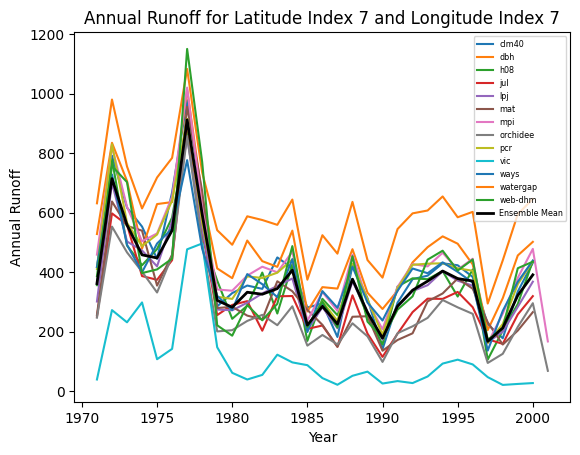

In [3]:

# Select the latitude and longitude index
lat_index = 7
lon_index = 7

# Calculate the annual runoff sum for each year and each model
qtot_annual_sum = []
for qtot_var in qtot_list:
    annual_sum = qtot_var.resample(time='A').sum(dim='time', keep_attrs=True)
    qtot_annual_sum.append(annual_sum)


    
qtot_ensemblemean_annual = qtot_ens_mean.groupby('time.year').sum(dim='time')

# Loop through the qtot_annual_sum list and plot the selected index
for i, qtot_annual in enumerate(qtot_annual_sum):
    model_name = file_names[i].split('_')[1]
    plt.plot(qtot_annual['time.year'], qtot_annual[:, lat_index, lon_index], label=model_name)

plt.plot(qtot_ensemblemean_annual['year'], qtot_ensemblemean_annual[:, lat_index, lon_index], label='Ensemble Mean', linewidth=2, color='black')

# Set the plot title, x-axis label, and y-axis label
plt.title('Annual Runoff for Latitude Index {} and Longitude Index {}'.format(lat_index, lon_index))
plt.xlabel('Year')
plt.ylabel('Annual Runoff')

# Add a legend
plt.legend(fontsize='xx-small')

# Show the plot
plt.show()

Same with the monhtly regime

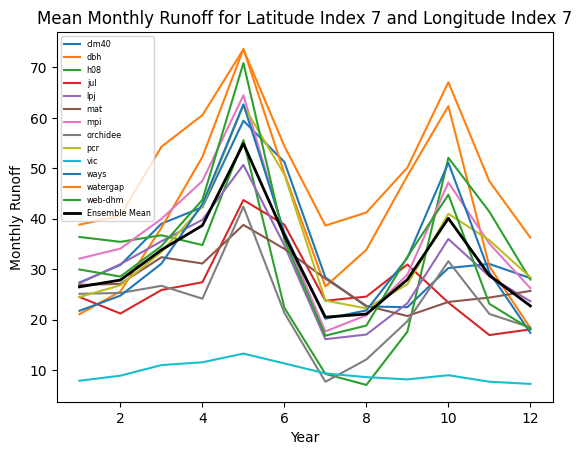

In [4]:
qtot_monthly_mean = []
for qtot_var in qtot_list:
    monthly_sum = qtot_var.resample(time='1M').sum(dim='time', keep_attrs=True)
    qtot_monthly_mean.append(monthly_sum.groupby('time.month').mean())
    
qtot_ensemblemean_monthlysum = qtot_ens_mean.resample(time = '1M').sum(dim='time')
qtot_ensemblemean_monthlymean = qtot_ensemblemean_monthlysum.groupby('time.month').mean()


# Loop through the qtot_monhtly_mean list and plot the selected index
for i, qtot_monthly in enumerate(qtot_monthly_mean):
    model_name = file_names[i].split('_')[1]
    plt.plot(qtot_monthly['month'], qtot_monthly[:, lat_index, lon_index], label=model_name)

plt.plot(qtot_ensemblemean_monthlymean['month'], qtot_ensemblemean_monthlymean[:, lat_index, lon_index], label='Ensemble Mean', linewidth=2, color='black')

# Set the plot title, x-axis label, and y-axis label
plt.title('Mean Monthly Runoff for Latitude Index {} and Longitude Index {}'.format(lat_index, lon_index))
plt.xlabel('Year')
plt.ylabel('Monthly Runoff')

# Add a legend
plt.legend(fontsize='xx-small')

# Show the plot
plt.show()

Now work with only the ensamble mean to obtain the maps

First signature; Mean annual Specific Runoff



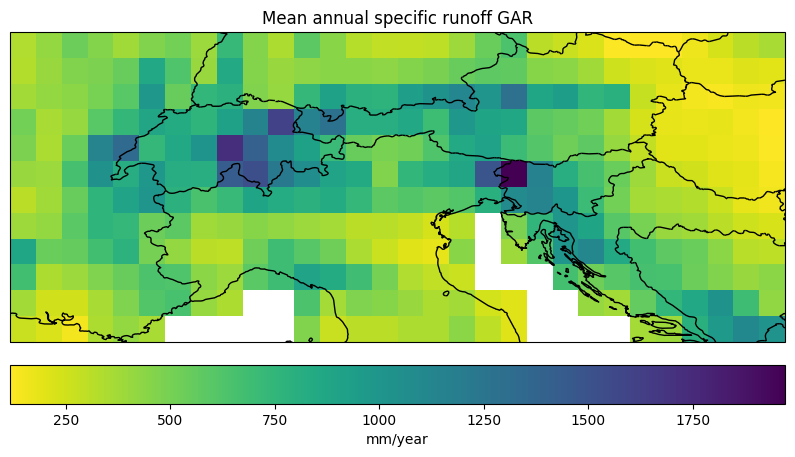

In [5]:
Q_mean = qtot_ens_mean.mean(dim='time')*365

masked_data = np.ma.masked_invalid(Q_mean)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Q_mean.lon, Q_mean.lat, masked_data, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Q_mean.lon, Q_mean.lat, masked_data, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Mean annual specific runoff GAR')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('mm/year')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()


Step 2: pardè Coefficient= mean monthly runoff(i= 1:12) / mean annual runoff Parde range = Max(Pardè) - Min(Pardè)

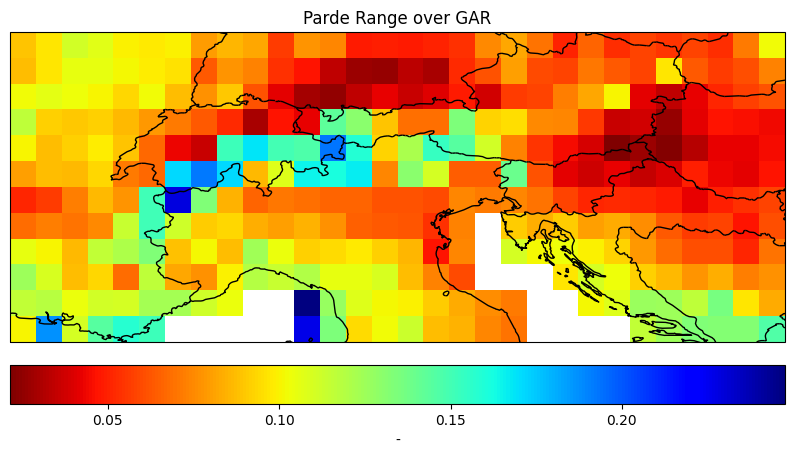

In [6]:
qmonthly= qtot_ens_mean.groupby('time.month').sum(dim='time')
qyearly= qtot_ens_mean.sum(dim='time')


Parde= qmonthly/qyearly
Parde_max= Parde.max(dim='month')
Parde_min= Parde.min(dim='month')

Range= Parde_max- Parde_min

masked_Range = np.ma.masked_invalid(Range)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('jet')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Range, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Range, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Parde Range over GAR')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

Now for the slope of the central part of the flow duration curve.

Slope_FDC = Q30-Q70/ Q_daily_mean



Normalized Low flows 

Q_95/qmean

Integral time scale

In [7]:
mean_daily = qtot_ens_mean.mean(dim='time')
variance = np.empty((1,12,30))
for i in range(0,12):
    for j in range(0,30):
        dummy= np.var(qtot_ens_mean[:,i,j])
        variance[:,i,j]= dummy 
        

q_normalized= qtot_ens_mean-mean_daily



acorr = np.empty((len(q_normalized),12,30))

for i in range(0,12):
    for j in range(0,30):
        dummy= np.correlate(q_normalized[:,i,j], q_normalized[:,i,j], 'full')[len(q_normalized)-1:] 
        acorr[:,i,j]= dummy/ variance[:,i,j]/len(q_normalized)
        



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/core/nputils.py:157: 

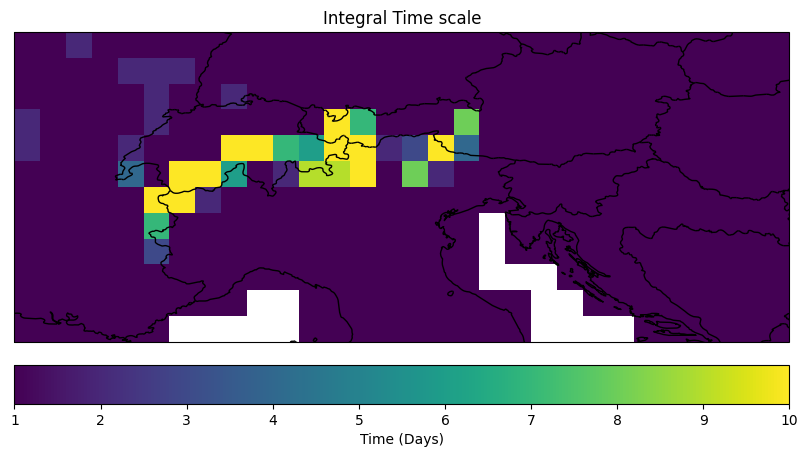

In [8]:
autocorr = np.array(acorr)
maxi = np.empty((1,12,30))

for i in range(0,12):
    for j in range(0,30):
            dummyy = np.where(autocorr[:,i,j] > 0.386)[0]
            if np.isnan(autocorr[:,i,j]).any() == 1:
                maxi[:,i,j]= np.nan
            elif np.isnan(autocorr[:,i,j]).any() == 0:
                maxi[0,i,j]= dummyy[-1]


masked_maxi = np.ma.masked_invalid(maxi)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_maxi[0,:,:], cmap=cmap,vmin=1, vmax=10,  transform=ccrs.PlateCarree())
ax.set_title('Integral Time scale')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('Time (Days)')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

Lets try another way to calculate the fdc: i want to create a fdc for each year, then i want to create the average year fdc.  Lets do it first in one pixel then expand over the whole region.

In [9]:
annual_fdc = np.empty((365,12,30,30))
yy = np.arange(1971,2001)
for i in range(0,29):
    for j in range(0,12):
        for k in range(0,30):
            dummy = np.sort(qtot_ens_mean[year== yy[i],j,k])[::-1]
            annual_fdc[:,j,k,i]= dummy[0:365]

annual_fdc.shape
    

(365, 12, 30, 30)

In [10]:
#plt.plot(np.arange(0,365), annual_fdc[:, 11, 10,1], label='Ensemble Mean', linewidth=2, color='black')
#plt.yscale("log")
#scelto apposta un pixel vuoto

Seems ok , lets do the mean fdc:

In [11]:
mean_fdc = np.mean(annual_fdc, axis= 3)
mean_fdc.shape

(365, 12, 30)

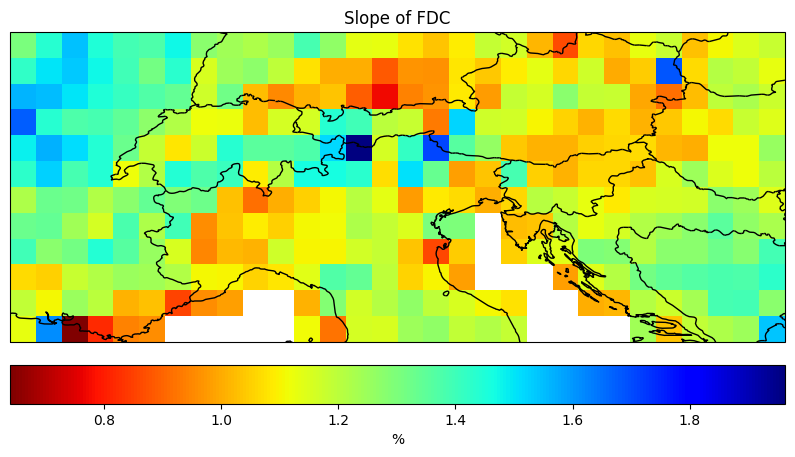

In [12]:
mean_daily = qtot_ens_mean.mean(dim='time')
exceeded_30= mean_fdc[111,:,:]
exceeded_70= mean_fdc[256,:,:]
mfdc= 100* (exceeded_30-exceeded_70)/(40*mean_daily)

masked_mfdc = np.ma.masked_invalid(mfdc)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('jet')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_mfdc, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_mfdc, cmap=inverted_cmap, transform=ccrs.PlateCarree())
ax.set_title('Slope of FDC')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('%')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

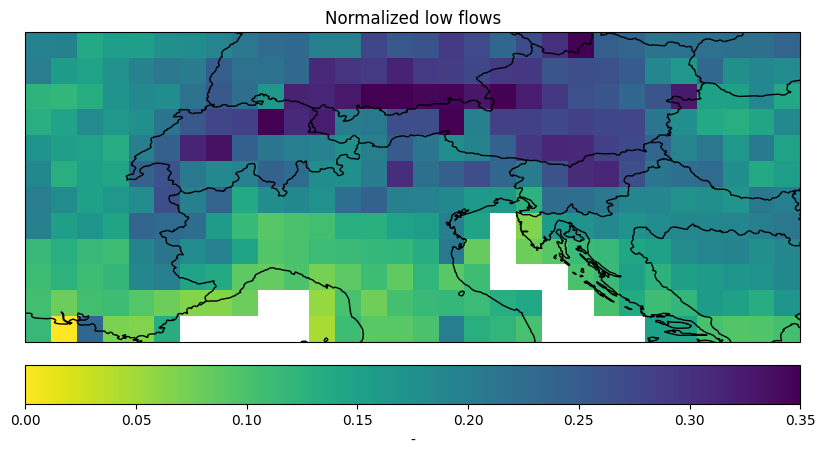

In [13]:
exceeded_95 =  mean_fdc[347,:,:]

Qlow = exceeded_95/mean_daily

masked_Qlow = np.ma.masked_invalid(Qlow)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=inverted_cmap, vmin=0, vmax=0.35, transform=ccrs.PlateCarree())
ax.set_title('Normalized low flows')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

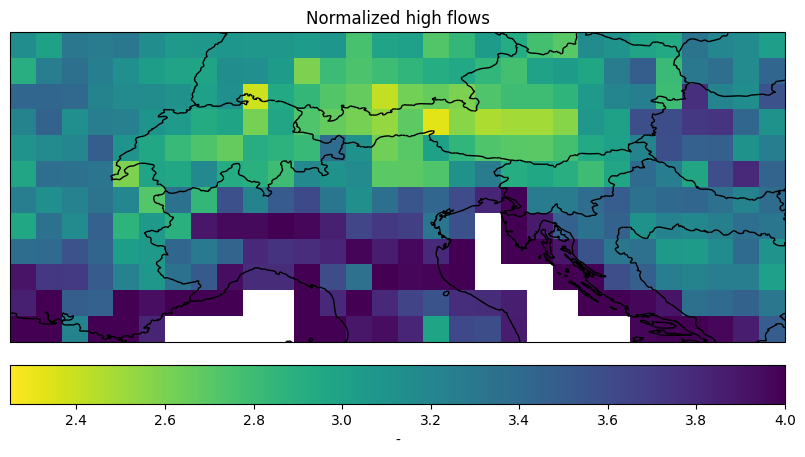

In [14]:
exceeded_5 =  mean_fdc[18,:,:]

Qlow = exceeded_5/mean_daily

masked_Qlow = np.ma.masked_invalid(Qlow)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('viridis')
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_Qlow, cmap=inverted_cmap, vmin=2.25, vmax=4, transform=ccrs.PlateCarree())
ax.set_title('Normalized high flows')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()

Ok, all the signatures for the past in the ensamble mean are derived. Now the analysis could go on for the variability. For instance for each signature i could take the model who has the largest variation of that signature in that pixel i.e. the largest difference compared to the ensamble mean, then plot for all the pixel and for each signature the relative variability for the whole region. 

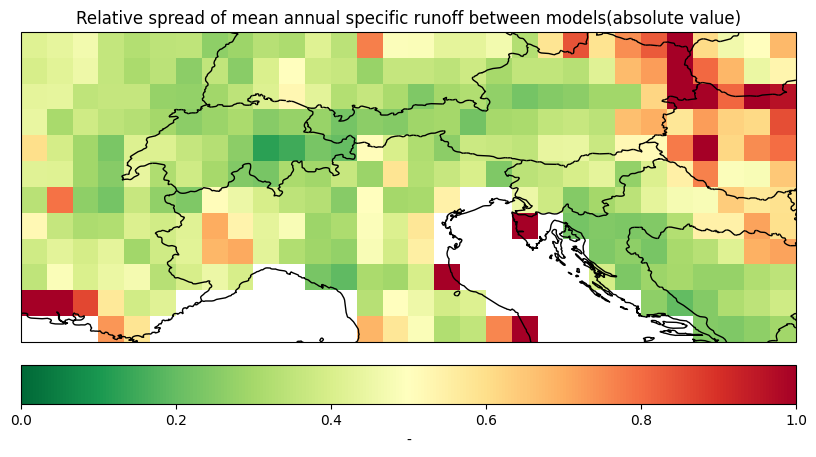

In [15]:
annualmeanrunoff_allmodels = []
for qtot_var in qtot_list:
    annualmean = qtot_var.mean(dim='time', keep_attrs=True)*365
    annualmeanrunoff_allmodels.append(annualmean)
    
    
max_variability = np.empty((1,12,30))
absolute_variability = np.empty((len(annualmeanrunoff_allmodels),12,30))
max_absolute_variability = np.empty((1,12,30))
for i in range(len(annualmeanrunoff_allmodels)):
            model_mean = annualmeanrunoff_allmodels[i]
            absolute_variability[i,:,:] = np.abs(model_mean - Q_mean)
            max_variability[:,:,:] = (absolute_variability[:,:,:].max(axis=0)) / Q_mean

            
masked_max_variability = np.ma.masked_invalid(max_variability)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cmap = plt.get_cmap('RdYlGn')
im = ax.pcolormesh(Range.lon, Q_mean.lat,masked_max_variability[0,:,:], cmap=cmap, transform=ccrs.PlateCarree())
inverted_cmap = cmap.reversed()
im = ax.pcolormesh(Range.lon, Q_mean.lat, masked_max_variability[0,:,:], cmap=inverted_cmap, vmin=0, vmax=1, transform=ccrs.PlateCarree())
ax.set_title('Relative spread of mean annual specific runoff between models(absolute value)')
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05)
cbar.ax.set_xlabel('-')
cbar.ax.xaxis.set_label_position('bottom')
plt.show()


In [16]:
absolute_variability[:,11,0]

array([         nan, 173.54836166, 146.70276446, 183.22771199,
        52.45164718, 350.44716168, 178.52119426,          nan,
        36.15181235, 190.75012788,          nan,  35.53645727,
       228.6195602 ])

seems like some models have different coastlines , or maybe different reference systems? In any case i like more this map than the previous that had too many pixels on the sea.

Importo i dati del GRDC:
Per prima cosa trimmo rispetto ai catchment troppo grandi rispetto alle dimensioni del pixel, poi vedo come sono distribuiti gli altri. 

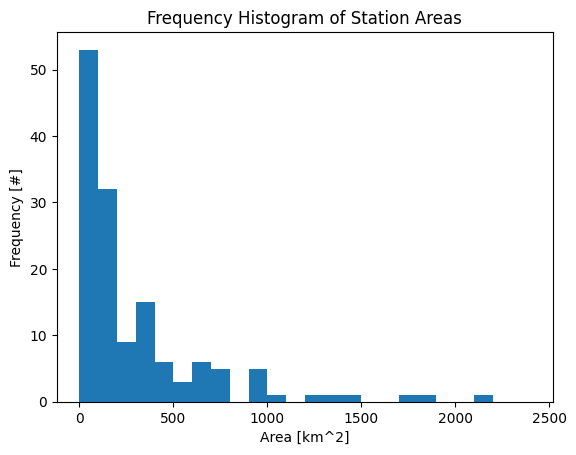

In [17]:
# Open the original dataset
dis_grdc = xr.open_dataset('GRDC-Daily.nc')
# Trim the dataset based on area

dis_grdc_trimmed=dis_grdc.where(dis_grdc.area >= 0, drop=True)
# Calculate the frequency histogram of station areas
bin_size = 100
bins = range(0, 2500, bin_size)
hist, bin_edges = np.histogram(dis_grdc_trimmed.area.values, bins=bins)

# Plot the frequency histogram
plt.bar(bin_edges[:-1], hist, width=bin_size, align='edge')
plt.xlabel('Area [km^2]')
plt.ylabel('Frequency [#]')
plt.title('Frequency Histogram of Station Areas')
plt.show()


In [18]:
##### Convert runoff from cubic meter per second to mm/day
runoff_mm_day = ((dis_grdc['runoff_mean'] / dis_grdc['area']) / 1000) * 86400

# Create a new dataset with restructured coordinates
new_dataset = xr.Dataset(
    {
        'runoff': runoff_mm_day,
    },
    coords={
        'time': dis_grdc['time'],
        'latitude': dis_grdc['geo_y'],
        'longitude': dis_grdc['geo_x'],
        'area': dis_grdc['area']
    }
)

new_dataset =new_dataset.sel(time=slice('1971-01-01', '2000-12-31'))
new_dataset = new_dataset.where(new_dataset['id'] != 6139391, drop=True)
new_dataset = new_dataset.where(new_dataset['id'] != 6128110, drop=True)
new_dataset = new_dataset.where(new_dataset['id'] != 6128701, drop=True)
# Print the new dataset
print(new_dataset)

qtot_obs=new_dataset['runoff']

<xarray.Dataset>
Dimensions:    (time: 10958, id: 141)
Coordinates:
  * time       (time) datetime64[ns] 1971-01-01 1971-01-02 ... 2000-12-31
  * id         (id) int32 6128710 6139201 6139250 ... 6948360 6948520 6948530
    latitude   (id) float32 44.25 43.88 44.02 44.22 ... 46.49 46.37 46.2 46.22
    longitude  (id) float32 6.934 6.539 6.253 6.275 ... 9.898 8.543 9.169 8.015
    area       (id) float32 167.0 655.0 375.0 165.0 ... 66.5 24.0 8.06 19.8
Data variables:
    runoff     (time, id) float64 1.097 0.5883 1.486 ... 1.724 1.501 0.624


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


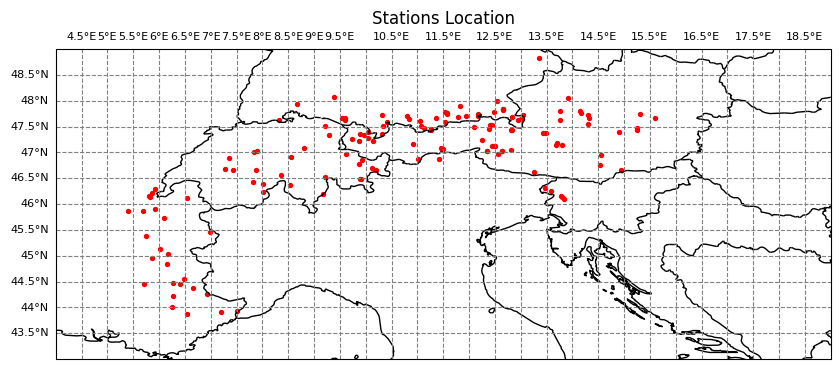

In [19]:


# Get the latitude and longitude coordinates of the stations
latitude = dis_grdc_trimmed['geo_y']
longitude = dis_grdc_trimmed['geo_x']

# Create a map projection
projection = ccrs.PlateCarree()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

# Plot the station locations
ax.scatter(longitude, latitude, color='red', marker='o',s=8, transform=projection)

# Add map features
ax.coastlines()
ax.set_extent([4, 19, 43, 49], crs=projection)
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray',
             xlocs=[4.50, 5.0, 5.5, 6.0, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5,
                    11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5, 15, 15.5, 16,
                    16.5, 17, 17.5, 18, 18.5, 19],
             ylocs=[43.0, 43.5, 44, 44.5, 45, 45.5, 46.0, 46.5, 47, 47.5, 48, 48.5],
             x_inline=False, y_inline=False)

gl.xlabels_bottom = False
gl.xlabel_style = {'rotation': 0, 'size': 8, 'color': 'black'}

# Move the y-axis labels to the right
gl.ylabels_right = False
gl.ylabel_style = {'rotation': 0, 'size': 8, 'color': 'black'}
# Set plot title and labels
ax.set_title('Stations Location')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.add_feature(cfeature.BORDERS)
# Show the plot
plt.show()

Now combine the station with the matching pixel

In [24]:

# Create an empty array with the desired dimensions and coordinates
combined_data = xr.DataArray(data=None, dims=['realizations', 'time', 'id'], coords={'realizations': np.arange(15), 'time': qtot_obs.time, 'id': qtot_obs.id})

# Assign the runoff timeseries from qtot_obs to the new array
combined_data[0, :, :] = qtot_obs

# Loop over the stations (ids)
for i, station_id in enumerate(qtot_obs.id.values):
    # Find the nearest pixel in qtot_concat based on latitude and longitude
    nearest_pixel = qtot_concat.sel(lat=qtot_obs.sel(id=station_id).latitude, lon=qtot_obs.sel(id=station_id).longitude, method='nearest')
    
    # Get the model timeseries for the nearest pixel
    model_timeseries = nearest_pixel.values
    
    # Assign the model timeseries to the combined array
    combined_data[1:, :, i] = model_timeseries
    
    
# Create the model names array
model_names = ['observations','clm40', 'dbh', 'ho8', 'jul', 'lpj', 'mat', 'mpi', 'orchidee', 'pcr', 'vic', 'ways', 'watergap', 'web-dhm', 'ensemble mean']

# Set the 'model' attribute for the model timeseries
combined_data = combined_data.assign_attrs(model=model_names)
combined_data = combined_data.astype(float)

# Find all time steps corresponding to the 29th of February
leap_year_dates = combined_data.time[combined_data.time.dt.is_leap_year & (combined_data.time.dt.month == 2) & (combined_data.time.dt.day == 29)]

# Remove the time steps corresponding to the 29th of February from the array
combined_data = combined_data.where(~combined_data.time.isin(leap_year_dates), drop=True)


# Print the combined array
print(combined_data)

<xarray.DataArray (realizations: 15, time: 10950, id: 141)>
array([[[1.09681436e+00, 5.88311456e-01, 1.48607984e+00, ...,
         4.31999989e-01, 2.14392044e-01, 6.54545530e-01],
        [1.06577245e+00, 5.79077833e-01, 1.48607984e+00, ...,
         4.31999989e-01, 2.14392044e-01, 6.98181862e-01],
        [1.06577245e+00, 5.32909918e-01, 1.54367986e+00, ...,
         4.31999989e-01, 2.14392044e-01, 7.41818233e-01],
        ...,
        [           nan, 2.18967943e+00, 1.91462403e+00, ...,
         1.87920016e+00, 1.52218358e+00, 6.06545435e-01],
        [           nan, 2.08415263e+00, 1.61279992e+00, ...,
         1.79279998e+00, 1.50074435e+00, 6.37090950e-01],
        [           nan, 1.96543502e+00, 1.40313609e+00, ...,
         1.72440003e+00, 1.50074435e+00, 6.24000054e-01]],

       [[2.16905476e+00, 5.92434802e+00, 2.06001338e+00, ...,
         2.66446201e+00, 2.74810733e+00, 2.21114616e+00],
        [2.13428563e+00, 9.88385745e-01, 2.03608723e+00, ...,
         2.58924962e+00

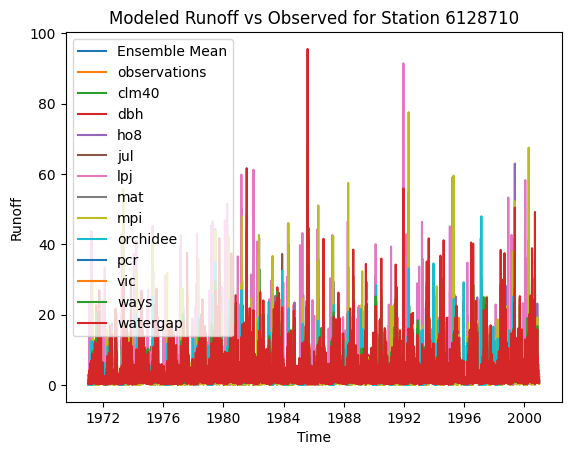

In [25]:

# Get the timeseries for the station with id index 0
daily_station1 = combined_data[:, :, 90]

# Get the model names from the 'model' attribute
model_names = combined_data.attrs['model']

# Update the plot code
plt.plot(daily_station1.time, daily_station1[14, :], label='Ensemble Mean')
for i, model in enumerate(model_names[0:13]):  # Exclude the first entry (station)
    plt.plot(daily_station1.time, daily_station1[i , :], label=model)



# Add legend with model names
plt.legend()

# Set x-axis and y-axis labels and title
plt.xlabel('Time')
plt.ylabel('Runoff')
plt.title(f"Modeled Runoff vs Observed for Station {combined_data.id.values[0]}")

# Show the plot
plt.show()

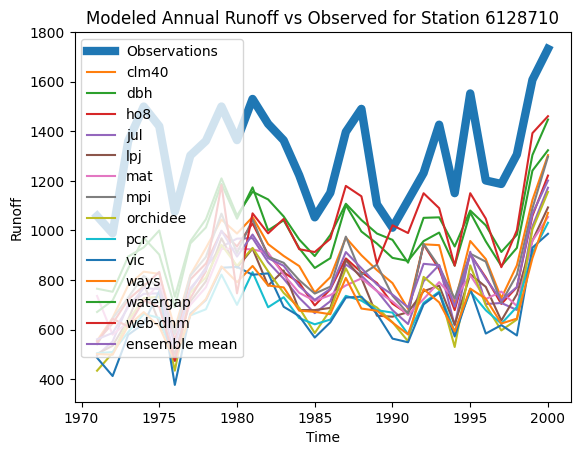

In [26]:
#vediamo l'annual
# Get the timeseries for the station with id index 0
annual_station1 = daily_station1.groupby('time.year').sum()

# Get the model names from the 'model' attribute
model_names = combined_data.attrs['model']

# Update the plot code
plt.plot(annual_station1.year, annual_station1[0, :], label='Observations', linewidth = 6)
#for model in enumerate(model_names[1:]): 
for i in range(1,15):# Exclude the first entry (station)
    plt.plot(annual_station1.year, annual_station1[i , :], label=annual_station1.attrs['model'][i])



# Add legend with model names
plt.legend()

# Set x-axis and y-axis labels and title
plt.xlabel('Time')
plt.ylabel('Runoff')
plt.title(f"Modeled Annual Runoff vs Observed for Station {combined_data.id.values[0]}")

# Show the plot
plt.show()

In [27]:
realizations = combined_data.realizations
ids = combined_data.id
years = np.unique(combined_data.time.dt.year)  # Get unique years
years_datetime = pd.to_datetime(years, format="%Y") 

annual_q95 = np.zeros((len(realizations), len(years), len(ids)))   
annual_q5 = np.zeros((len(realizations), len(years), len(ids)))
total_sorted= np.zeros((len(realizations), len(time), len(ids)))
for k, id in enumerate(ids):
    for i, realization in enumerate(realizations):
                       for j, year in enumerate(years):
      
                               runoff_yearly = combined_data[realization, combined_data.time.dt.year == year, ids==id ]
                               sorted_yearly = np.sort(runoff_yearly.values.flatten())[::-1]  # Sort yearly values in descending order
                               total_sorted[i, j*365:(j+1)*365, k] = sorted_yearly[:365]
                               annual_q95[i, j, k] = total_sorted[i,347+365*(j), k]  # Extract 347th element
                               annual_q5[i, j, k] = total_sorted[i,18+365*(j), k] # Extract 18th element
            

            
annual_q95 = xr.DataArray(
    annual_q95,
    coords=[realizations, years_datetime, ids],
    dims=["realization", "time", "id"],
    name="annual_q95"
)

annual_q5 = xr.DataArray(
    annual_q5,
    coords=[realizations, years_datetime, ids],
    dims=["realization", "time", "id"],
    name="annual_q5"
)

# Assign the 'model' attribute to annual_q5
annual_q5 = annual_q5.assign_attrs(model=model_names)

# Assign the 'model' attribute to annual_q95
annual_q95 = annual_q95.assign_attrs(model=model_names)

In [83]:
for k, id in enumerate(ids):
    for i, realization in enumerate(realizations):
        for j, year in enumerate(years):
            runoff_yearly = combined_data[realization, combined_data.time.dt.year == year, ids == id]
            sorted_yearly = np.sort(runoff_yearly.values.flatten())[::-1]  # Sort yearly values in descending order
            total_sorted[i, j * 365:(j + 1) * 365, k] = sorted_yearly[:365]

            nan_count = np.isnan(runoff_yearly).sum()
            if nan_count <= 15:
                annual_q95[i, j, k] = total_sorted[i, 347 + 365 * j, k]  # Extract 347th element
                annual_q5[i, j, k] = total_sorted[i, 18 + 365 * j, k]
            else:
                annual_q95[i, j, k] = np.nan
                annual_q5[i, j, k] = np.nan

annual_q95 = xr.DataArray(
    annual_q95,
    coords=[realizations, years_datetime, ids],
    dims=["realization", "time", "id"],
    name="annual_q95"
)

annual_q5 = xr.DataArray(
    annual_q5,
    coords=[realizations, years_datetime, ids],
    dims=["realization", "time", "id"],
    name="annual_q5"
)

# Assign the 'model' attribute to annual_q5
annual_q5 = annual_q5.assign_attrs(model=model_names)

# Assign the 'model' attribute to annual_q95
annual_q95 = annual_q95.assign_attrs(model=model_names)

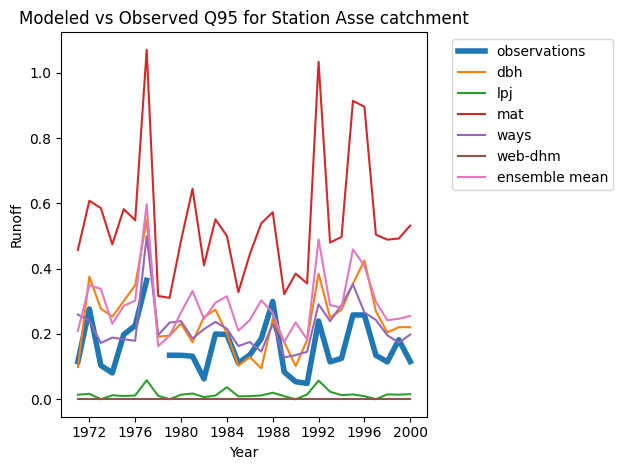

In [28]:
# Select the data for Asse
asse_q95 = annual_q95.sel(id=6139250)


# Plot the realizations
for i, realization in enumerate(asse_q95.realization):
    # Check if the index matches the desired conditions
    if i == 0:
        # Plot the realization with index 0 in a thicker line
        plt.plot(asse_q95.time, asse_q95[realization, :], linewidth=4, label=asse_q95.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        # Plot only the realizations with the specified indices
        plt.plot(asse_q95.time, asse_q95[realization, :], label=asse_q95.attrs['model'][i])

# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Runoff')
plt.title('Modeled vs Observed Q95 for Station Asse catchment')

# Move the legend outside the graph to the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust the layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

High flows

In [146]:
#correlation
import scipy
from scipy.stats import pearsonr
# Select the data for the realization with id=0
observation_q5_high = annual_q5.sel(realization=0)

# Calculate the Pearson correlation coefficient for each realization
correlations_highflows = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q5.id.values):
    for j, realization in enumerate(annual_q5.realization.values):

        data_current = annual_q5.sel(realization=realization, id=station)
        
    # Find the indices where observation_q5_high has non-NaN values
        valid_indices = np.where(~np.isnan(observation_q5_high[:, i]))[0]
        
        # Exclude the years with missing values from observation_q5_high and data_current
        observation_valid = observation_q5_high[valid_indices]
        data_valid = data_current[valid_indices]
        
        # Check if there are valid values in both observation_valid and data_valid
        if len(observation_valid) > 0 and len(data_valid) > 0:
            correlation_h, _ = pearsonr(observation_valid[:, i], data_valid[:])
            correlations_highflows[j, i] = correlation_h


# Print the correlations
print(correlations_highflows)


#ratio between simulated and observed mean

observation_mean_q5_high = observation_q5_high.mean(dim = 'time')

ratio_mean_high = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q5.id.values):
    for j, realization in enumerate(annual_q5.realization.values):

        data_current = annual_q5.sel(realization=realization, id=station).mean(dim='time')
        ratio_mean_high[j,i]= data_current/observation_mean_q5_high[i]
        
        


        
print(ratio_mean_high)

#ratio between simulated and observed std


observation_std_q5_high = observation_q5_high.std(dim= 'time')
ratio_std_high = []

ratio_std_high = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q5.id.values):
    for j, realization in enumerate(annual_q5.realization.values):
            
        data_current = annual_q5.sel(realization=realization, id=station).std(dim='time')
        ratio_std_high[j,i]= data_current/observation_std_q5_high[i]
        
        


        
print(ratio_std_high)

KGE_q5 = np.zeros((len(realizations), len(ids)))
for i in range (0,141):
    for j in range (0,15):
        KGE_q5[j,i] = 1 - np.sqrt(((1-correlations_highflows[j,i])**2)+((1-ratio_mean_high[j,i])**2)+((1-ratio_std_high[j,i])**2))
        
        

print(KGE_q5)


KGE_q5 = np.transpose(KGE_q5)        

#save as csv

np.savetxt('KGE_q5.csv', KGE_q5, delimiter=',')

[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.80078584 0.43251352 0.55061825 ... 0.62559279 0.85664854 0.80515189]
 [0.6875867  0.43780116 0.47696053 ... 0.59051859 0.81646084 0.84901493]
 ...
 [0.62578831 0.70898225 0.56364913 ... 0.77417323 0.66986718 0.7465307 ]
 [0.68813577 0.67877213 0.29638552 ... 0.74034395 0.81194896 0.62793075]
 [0.69098085 0.7043019  0.6277566  ... 0.80285042 0.89323374 0.85550537]]
[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.89152007 1.28573774 1.60872582 ... 0.80140956 0.52215626 1.37092886]
 [1.09964776 2.18002615 2.40889605 ... 0.93183026 0.59628681 1.44231856]
 ...
 [0.58041255 1.60668483 1.20793097 ... 1.15387183 0.51485144 1.42380234]
 [1.58149996 1.49258351 3.70610191 ... 1.7252024  1.09511882 2.09979858]
 [0.69390236 1.37635264 1.60628415 ... 0.77884748 0.44786847 0.98664853]]
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.00409016 2.34534139 1.78683657 ... 

array([ 1.        , -0.48782741, -0.6086152 , -1.80010157,  0.39221095,
       -0.38916149, -0.99369827, -0.71541183, -0.25723942,  0.31262938,
        0.13840958, -0.54016924, -0.44013569, -1.01390828, -0.15192793])

Low flows

In [145]:
# Select the data for the realization with id=0
observation_q95_low = annual_q95.sel(realization=0)

# Calculate the Pearson correlation coefficient for each realization
correlations_lowflows = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q95.id.values):
    for j, realization in enumerate(annual_q95.realization.values):

        data_current = annual_q95.sel(realization=realization, id=station)
        
    # Find the indices where observation_q5_high has non-NaN values
        valid_indices = np.where(~np.isnan(observation_q95_low[:, i]))[0]
        
        # Exclude the years with missing values from observation_q5_high and data_current
        observation_valid = observation_q95_low[valid_indices]
        data_valid = data_current[valid_indices]
        
        # Check if there are valid values in both observation_valid and data_valid
        if len(observation_valid) > 0 and len(data_valid) > 0:
            if np.std(observation_valid[:, i]) == 0 or np.std(data_valid[:]) == 0:
                correlation_l = 0  # Set correlation to 0 if one of the arrays is constant
            else:
                correlation_l, _ = pearsonr(observation_valid[:, i], data_valid[:])
            correlations_lowflows[j, i] = correlation_l


# Print the correlations
#print(correlations_lowflows)


observation_mean_q95_low = observation_q95_low.mean(dim = 'time')

ratio_mean_low = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q5.id.values):
    for j, realization in enumerate(annual_q5.realization.values):

        data_current = annual_q95.sel(realization=realization, id=station).mean(dim='time')
        ratio_mean_low[j,i]= data_current/observation_mean_q95_low[i]
        
        


        
#print(ratio_mean_low)




observation_std_q95_low = observation_q95_low.std(dim = 'time')

ratio_std_low = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q95.id.values):
    for j, realization in enumerate(annual_q95.realization.values):

        data_current = annual_q95.sel(realization=realization, id=station).std(dim='time')
        ratio_std_low[j,i]= data_current/observation_std_q95_low[i]
        
        


        
#print(ratio_std_low)



KGE_q95 = np.zeros((len(realizations), len(ids)))
for i in range (0,141):
    for j in range (0,15):
        KGE_q95[j,i] = 1 - np.sqrt(((1-correlations_lowflows[j,i])**2)+((1-ratio_mean_low[j,i])**2)+((1-ratio_std_low[j,i])**2))
        
KGE_q95 = np.transpose(KGE_q95)        

#save as csv

np.savetxt('KGE_q95.csv', KGE_q95, delimiter=',')

In [139]:
KGE_q95[:,1]

array([ 1.        ,  0.38660793,  0.3393197 , -0.14362649,  0.20583858,
       -0.43782308, -0.34154103, -0.39033463, -0.40700978,  0.02742414,
       -0.58682604,  0.42626787,  0.33012105, -0.73205081,  0.1220078 ])

Mean monthly regime

In [144]:
# Resample combined_data to monthly frequency
monthly_data = combined_data.resample(time='M').sum()

# Groupby month and calculate mean within each group
mean_monthly = monthly_data.groupby('time.month').mean(dim='time')
mean_monthly= mean_monthly.assign_attrs(model=model_names)
#print(mean_monthly)


#Correlation

# Select the data for the realization with id=0
observation_monthly = mean_monthly.sel(realizations=0)

# Calculate the Pearson correlation coefficient for each realization
correlations_monthly = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q95.id.values):
    for j, realization in enumerate(annual_q95.realization.values):
        data_current_realization = mean_monthly.sel(realizations=realization, id=station)
        correlation_m, _ = pearsonr(observation_monthly[:,i], data_current_realization[:])
        correlations_monthly[j,i]= correlation_m



print(correlations_monthly)

observation_mean_monthly_regime = observation_monthly.mean(dim= 'month')
ratio_mean_monthly  = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q95.id.values):
    for j, realization in enumerate(annual_q95.realization.values):
        data_current_realization = mean_monthly.sel(realizations=realization, id=station).mean(dim='month')
        ratio_mean_monthly[j,i] = data_current_realization/observation_mean_monthly_regime[i]



print(ratio_mean_monthly)

observation_std_monthly_regime = observation_monthly.std(dim= 'month')
ratio_std_monthly  = np.zeros((len(realizations), len(ids)))
for i, station in enumerate(annual_q95.id.values):
    for j, realization in enumerate(annual_q95.realization.values):
        data_current_realization = mean_monthly.sel(realizations=realization, id=station).std(dim='month')
        ratio_std_monthly[j,i] = data_current_realization/observation_std_monthly_regime[i]
        
        
print(ratio_std_monthly)


KGE_monthly = np.zeros((len(realizations), len(ids)))
for i in range (0,141):
    for j in range (0,15):
        KGE_monthly[j,i] = 1 - np.sqrt(((1-correlations_monthly[j,i])**2)+((1-ratio_mean_monthly[j,i])**2)+((1-ratio_std_monthly[j,i])**2))
        
        

print(KGE_monthly)

#save as csv

np.savetxt('KGE_monthly.csv', KGE_monthly, delimiter=',')


[[ 1.          1.          1.         ...  1.          1.
   1.        ]
 [ 0.61825374  0.11257271  0.91506641 ...  0.7127359   0.9075166
   0.88450817]
 [ 0.49915679  0.14996665  0.73127659 ...  0.61917409  0.89275896
   0.56139728]
 ...
 [ 0.14435205  0.07088884  0.99454358 ...  0.8664891   0.9784451
   0.80840864]
 [-0.22257972  0.09290658  0.81325882 ...  0.14630511  0.65489815
  -0.14878827]
 [ 0.21335881  0.05872625  0.9590632  ...  0.59174376  0.90352357
   0.63202326]]
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.12929065 1.11008987 1.69664383 ... 0.85966398 0.6221884  1.22360864]
 [1.2463711  1.37220986 1.9357001  ... 0.93722648 0.68270339 1.27545288]
 ...
 [0.70569287 1.12592594 0.93748037 ... 0.85489325 0.46955547 1.3388116 ]
 [1.25043993 0.83444387 1.92176957 ... 1.01924643 0.75786671 1.46003601]
 [1.00626041 0.96752907 1.50459268 ... 0.82842701 0.57866257 1.17327866]]
[[1.         1.         1.         ... 1.         1.         1.        ]
 

In [142]:
KGE_eachstation_allmodels_q5= KGE_q

KGE_eachstation_allmodels_q95 = KGE

array([ 1.        ,  0.10568327,  0.0536448 , -0.0993438 ,  0.01366223,
        0.01320103,  0.06465838,  0.05105471, -0.07516879,  0.05973196,
       -0.13792292,  0.04300601,  0.05853937,  0.034649  ,  0.04019192])

In [118]:
mean_monthly_allstations = mean_monthly.median(dim='id')
mean_monthly_allstations = mean_monthly_allstations.assign_attrs(model=model_names)

# Select the data for the realization with id=0
observation_monthly = mean_monthly.sel(realizations=0)

# Calculate the Pearson correlation coefficient for each realization
correlations_monthly = []
for realization in mean_monthly_allstations.realizations.values:
    data_current_realization = mean_monthly_allstations.sel(realizations=realization)
    correlation_m, _ = pearsonr(observation_monthly, data_current_realization)
    correlations_monthly.append(correlation_m)

correlations_monthly = np.array(correlations_monthly)

correlations_monthly



array([ 1.        ,  0.85131487,  0.96365339,  0.23855918,  0.6089305 ,
       -0.46507916,  0.63007926,  0.53869862,  0.2153382 ,  0.90511024,
        0.79834186,  0.89510266,  0.96749585,  0.22452111,  0.83750389])

In [ ]:
observation_mean_monthly = observation_monthly.mean()
relative_difference_mean_monthly = []

for realization in mean_monthly_allstations.realizations.values:
    mean_current_realization = mean_monthly_allstations.sel(realizations=realization).mean()
    relative_mm =(mean_current_realization-observation_mean_monthly)/observation_mean_monthly
    relative_difference_mean_monthly.append(relative_mm)

relative_difference_mean_monthly = np.array(relative_difference_mean_monthly)

print(relative_difference_mean_monthly)
# Export the DataFrame to a CSV file
np.savetxt('mean_monthly_mean_nosoc.csv',relative_difference_mean_monthly, delimiter=',')


In [ ]:
observation_std_monthly = observation_monthly.std()
relative_difference_std_monthly = []

for realization in mean_monthly_allstations.realizations.values:
    std_current_realization = mean_monthly_allstations.sel(realizations=realization).std()
    relative_ms =(std_current_realization-observation_std_monthly)/observation_std_monthly
    relative_difference_std_monthly.append(relative_ms)

relative_difference_std_monthly = np.array(relative_difference_std_monthly)

print(relative_difference_std_monthly)

# Export the DataFrame to a CSV file
np.savetxt('mean_monthly_std_nosoc.csv',relative_difference_std_monthly, delimiter=',')

Plotto le curve median di tutti i catchments per i tre hydrological indicators:

In [ ]:
# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Q5 Median of all catchments
axs[0].set_title('Q5 Median of all catchments')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Runoff[mm/day]')
for i, realization in enumerate(annual_q5_allstations.realization):
    if i == 0:
        axs[0].plot(annual_q5_allstations.time, annual_q5_allstations[realization, :], linewidth=4, label=annual_q5_allstations.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[0].plot(annual_q5_allstations.time, annual_q5_allstations[realization, :], label=annual_q5_allstations.attrs['model'][i])


# Plot for Q95 Median of all catchments
axs[1].set_title('Q95 Median of all catchments')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Runoff[mm/day]')
for i, realization in enumerate(annual_q95_allstations.realization):
    if i == 0:
        axs[1].plot(annual_q95_allstations.time, annual_q95_allstations[realization, :], linewidth=4, label=annual_q95_allstations.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[1].plot(annual_q95_allstations.time, annual_q95_allstations[realization, :], label=annual_q95_allstations.attrs['model'][i])

# Plot for Mean Monthly Median of all catchments
axs[2].set_title('Mean Monthly Median of all catchments')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Runoff[mm/month]')
for i, realization in enumerate(mean_monthly_allstations.realizations):
    if i == 0:
        axs[2].plot(mean_monthly_allstations.month, mean_monthly_allstations[realization, :], linewidth=4, label=mean_monthly_allstations.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[2].plot(mean_monthly_allstations.month, mean_monthly_allstations[realization, :], label=mean_monthly_allstations.attrs['model'][i])

# Adjust the layout to make room for the legend
plt.tight_layout()

# Move the legend outside the graph to the right
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

Plotto le curve degli indicators ma per 3 selected representative catchments: 
1) Ova da Cluozza - catchment piccolo e situato in alto
2) Danube - catchment di dimensioni comparabili al pixel situato a media altezza
3) Rhone - catchment grande 6x pixel situato primariamente in pianura 

In [ ]:
ova_da_cluozza_q5 = annual_q5.sel(id=6943115)
ova_da_cluozza_q95 = annual_q95.sel(id=6943115)
ova_da_cluozza_mm= mean_monthly.sel(id=6943115)

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Q5
axs[0].set_title('Q5 Ova da Cluozza')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Runoff[mm/day]')
for i, realization in enumerate(ova_da_cluozza_q5.realization):
    if i == 0:
        axs[0].plot(ova_da_cluozza_q5.time, ova_da_cluozza_q5[realization, :], linewidth=4, label=ova_da_cluozza_q5.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[0].plot(ova_da_cluozza_q5.time, ova_da_cluozza_q5[realization, :], label=ova_da_cluozza_q5.attrs['model'][i])

# Plot for Q95
axs[1].set_title('Q95 Ova da Cluozza')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Runoff[mm/day]')
for i, realization in enumerate(ova_da_cluozza_q95.realization):
    if i == 0:
        axs[1].plot(ova_da_cluozza_q95.time, ova_da_cluozza_q95[realization, :], linewidth=4, label=ova_da_cluozza_q95.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[1].plot(ova_da_cluozza_q95.time, ova_da_cluozza_q95[realization, :], label=ova_da_cluozza_q95.attrs['model'][i])

# Plot for Mean Monthly
axs[2].set_title('Mean Monthly Ova da Cluozza')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Runoff [mm/month]')
for i, realization in enumerate(ova_da_cluozza_mm.realizations):
    if i == 0:
        axs[2].plot(ova_da_cluozza_mm.month, ova_da_cluozza_mm[realization, :], linewidth=4, label=ova_da_cluozza_mm.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[2].plot(ova_da_cluozza_mm.month, ova_da_cluozza_mm[realization, :], label=ova_da_cluozza_mm.attrs['model'][i])

# Adjust the layout to make room for the legend
plt.tight_layout()

# Move the legend outside the graph to the right
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [ ]:
danube_q5 = annual_q5.sel(id=6342970)
danube_q95 = annual_q95.sel(id=6342970)
danube_mm = mean_monthly.sel(id=6342970)



# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Q5 of Danube catchment
axs[0].set_title('Q5 for Danube catchment')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Runoff[mm/day]')
for i, realization in enumerate(danube_q5.realization):
    if i == 0:
        axs[0].plot(danube_q5.time, danube_q5[realization, :], linewidth=4, label=danube_q5.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[0].plot(danube_q5.time, danube_q5[realization, :], label=danube_q5.attrs['model'][i])


# Plot for Q95 of Danube catchment
axs[1].set_title('Q95 for Danube catchment')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Runoff[mm/day]')
for i, realization in enumerate(danube_q95.realization):
    if i == 0:
        axs[1].plot(danube_q95.time, danube_q95[realization, :], linewidth=4, label=danube_q95.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[1].plot(danube_q95.time, danube_q95[realization, :], label=danube_q95.attrs['model'][i])

# Plot for Mean Monthly of Danube catchment
axs[2].set_title('Mean Monthly regime for Danube catchment')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Runoff[mm/month]')
for i, realization in enumerate(danube_mm.realizations):
    if i == 0:
        axs[2].plot(danube_mm.month, danube_mm[realization, :], linewidth=4, label=danube_mm.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[2].plot(danube_mm.month, danube_mm[realization, :], label=danube_mm.attrs['model'][i])

# Adjust the layout to make room for the legend
plt.tight_layout()

# Move the legend outside the graph to the right
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [ ]:
rhone_q5 = annual_q5.sel(id=6139391)
rhone_q95 = annual_q95.sel(id=6139391)
rhone_mm = mean_monthly.sel(id=6139391)
# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for Q5 of Rhone catchment
axs[0].set_title('Q5 for Rhone catchment')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Runoff[mm/day]')
for i, realization in enumerate(rhone_q5.realization):
    if i == 0:
        axs[0].plot(rhone_q5.time, rhone_q5[realization, :], linewidth=4, label=rhone_q5.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[0].plot(rhone_q5.time, rhone_q5[realization, :], label=rhone_q5.attrs['model'][i])


# Plot for Q95 of Rhone catchment
axs[1].set_title('Q95 for Rhone catchment')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Runoff[mm/day]')
for i, realization in enumerate(rhone_q95.realization):
    if i == 0:
        axs[1].plot(rhone_q95.time, rhone_q95[realization, :], linewidth=4, label=rhone_q95.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[1].plot(rhone_q95.time, rhone_q95[realization, :], label=rhone_q95.attrs['model'][i])

# Plot for Mean Monthly of Rhone catchment
axs[2].set_title('Mean Monthly regime for Rhone catchment')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Runoff[mm/month]')
for i, realization in enumerate(rhone_mm.realizations):
    if i == 0:
        axs[2].plot(rhone_mm.month, rhone_mm[realization, :], linewidth=4, label=rhone_mm.attrs['model'][i])
    elif i in [2, 5, 6, 11, 13, 14]:
        axs[2].plot(rhone_mm.month, rhone_mm[realization, :], label=rhone_mm.attrs['model'][i])

# Adjust the layout to make room for the legend
plt.tight_layout()

# Move the legend outside the graph to the right
axs[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

Quello che voglio fare ora è rankare il best performing model( quindi l'ensemble mean ) , però questa volta su ogni stazione, poi assegnare a ogni stazione le relative caratteristiche di area ed elevation, e ricavare degli scatter plot su tutti gli indicatori  e tutte le measure statistiche. 

In [ ]:



ensemble_allstations_q5 = annual_q5.sel(realization= 14)
ensemble_allstations_q95 = annual_q95.sel(realization= 14)
ensemble_allstations_mm = mean_monthly.sel(realizations= 14)

obs_allstations_q5 = annual_q5.sel(realization= 0)
obs_allstations_q95 = annual_q95.sel(realization= 0)
obs_allstations_mm = mean_monthly.sel(realizations= 0)



In [ ]:




# Calculate the Pearson correlation coefficient for each realization
correlations_highflows_eachstation = []
for station in annual_q5.id.values:
    data_for_ens = ensemble_allstations_q5[:,ensemble_allstations_q5.id ==station]
    data_for_obs = obs_allstations_q5[:,obs_allstations_q5.id ==station]
    correlation_h_es, _ = pearsonr(data_for_obs[:,0], data_for_ens[:,0])
    correlations_highflows_eachstation.append(correlation_h_es)

correlations_highflows_eachstation = np.array(correlations_highflows_eachstation)

# Save the array as a CSV file

print(correlations_highflows_eachstation)

#np.savetxt('high_correlations_nosoc_allstations.csv', correlations_highflows, delimiter=',')

# Calculate the Pearson correlation coefficient for each realization
relative_difference_mean_q5_eachstation = []
for station in annual_q5.id.values:
    data_for_ens = ensemble_allstations_q5[:,ensemble_allstations_q5.id ==station].mean()
    data_for_obs = obs_allstations_q5[:,obs_allstations_q5.id ==station].mean()
    relative_mean_q5_es = (data_for_ens-data_for_obs)/data_for_obs
    relative_difference_mean_q5_eachstation.append(relative_mean_q5_es)


relative_difference_mean_q5_eachstation = np.array(relative_difference_mean_q5_eachstation)

print(relative_difference_mean_q5_eachstation)


# Calculate the Pearson correlation coefficient for each realization
relative_difference_std_q5_eachstation = []
for station in annual_q5.id.values:
    data_for_ens = ensemble_allstations_q5[:,ensemble_allstations_q5.id ==station].std()
    data_for_obs = obs_allstations_q5[:,obs_allstations_q5.id ==station].std()
    relative_std_q5_es = (data_for_ens-data_for_obs)/data_for_obs
    relative_difference_std_q5_eachstation.append(relative_std_q5_es)


relative_difference_std_q5_eachstation = np.array(relative_difference_std_q5_eachstation)

print(relative_difference_std_q5_eachstation)



In [ ]:
# Calculate the Pearson correlation coefficient for each realization
correlations_lowflows_eachstation = []
for station in annual_q95.id.values:
    data_for_ens = ensemble_allstations_q95[:,ensemble_allstations_q95.id ==station]
    data_for_obs = obs_allstations_q95[:,obs_allstations_q95.id ==station]
    correlation_l_es, _ = pearsonr(data_for_obs[:,0], data_for_ens[:,0])
    correlations_lowflows_eachstation.append(correlation_l_es)

correlations_lowflows_eachstation = np.array(correlations_lowflows_eachstation)

# Save the array as a CSV file

print(correlations_lowflows_eachstation)

#np.savetxt('high_correlations_nosoc_allstations.csv', correlations_highflows, delimiter=',')

# Calculate the Pearson correlation coefficient for each realization
relative_difference_mean_q95_eachstation = []
for station in annual_q95.id.values:
    data_for_ens = ensemble_allstations_q95[:,ensemble_allstations_q95.id ==station].mean()
    data_for_obs = obs_allstations_q95[:,obs_allstations_q95.id ==station].mean()
    relative_mean_q95_es = (data_for_ens-data_for_obs)/data_for_obs
    relative_difference_mean_q95_eachstation.append(relative_mean_q95_es)


relative_difference_mean_q95_eachstation = np.array(relative_difference_mean_q95_eachstation)

print(relative_difference_mean_q95_eachstation)


# Calculate the Pearson correlation coefficient for each realization
relative_difference_std_q95_eachstation = []
for station in annual_q5.id.values:
    data_for_ens = ensemble_allstations_q95[:,ensemble_allstations_q95.id ==station].std()
    data_for_obs = obs_allstations_q95[:,obs_allstations_q95.id ==station].std()
    relative_std_q95_es = (data_for_ens-data_for_obs)/data_for_obs
    relative_difference_std_q95_eachstation.append(relative_std_q95_es)


relative_difference_std_q95_eachstation = np.array(relative_difference_std_q95_eachstation)

print(relative_difference_std_q95_eachstation)



In [ ]:
dis_grdc = dis_grdc.where(dis_grdc['id'] != 6128110, drop=True)
dis_grdc= dis_grdc.where(new_dataset['id'] != 6128701, drop=True)
# Create a DataFrame with the desired columns
results_allstations_q5 = pd.DataFrame({
    'id': annual_q5.id.values,
    'correlations': correlations_highflows_eachstation,
    'meandiff': relative_difference_mean_q5_eachstation,
    'stddiff': relative_difference_std_q5_eachstation,
    'area': dis_grdc['area'],
})

# Filter data within the area range of 0 to 2500
filtered_results_q5 = results_allstations_q5[results_allstations_q5['area'].between(0, 500)]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatterplot for correlations
axes[0].scatter(filtered_results_q5['area'], filtered_results_q5['correlations'])
axes[0].set_xlabel('Area[km^2]')
axes[0].set_ylabel('Correlation')
axes[0].set_title('Area vs. Correlation')

# Plot scatterplot for relative difference in mean
axes[1].scatter(filtered_results_q5['area'],filtered_results_q5['meandiff'])
axes[1].set_xlabel('Area[km^2]')
axes[1].set_ylabel('Relative difference in mean')
axes[1].set_title('Area vs. Relative difference in mean')

# Plot scatterplot for relative difference in standard deviation
axes[2].scatter(filtered_results_q5['area'], filtered_results_q5['stddiff'])
axes[2].set_xlabel('Area [km^2]')
axes[2].set_ylabel('Relative difference in standard deviation')
axes[2].set_title('Area vs. Relative difference in standard deviation')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
# Create a DataFrame with the desired columns
results_allstations_q95 = pd.DataFrame({
    'id': annual_q5.id.values,
    'correlations': correlations_lowflows_eachstation,
    'meandiff': relative_difference_mean_q95_eachstation,
    'stddiff': relative_difference_std_q95_eachstation,
    'area': dis_grdc['area'],
})

# Filter data within the area range of 0 to 2500
filtered_results_q95 = results_allstations_q95[results_allstations_q95['area'].between(0, 500)]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatterplot for correlations
axes[0].scatter(filtered_results_q95['area'], filtered_results_q95['correlations'])
axes[0].set_xlabel('Area[km^2]')
axes[0].set_ylabel('Correlation')
axes[0].set_title('Area vs. Correlation')

# Plot scatterplot for relative difference in mean
axes[1].scatter(filtered_results_q95['area'],filtered_results_q95['meandiff'])
axes[1].set_xlabel('Area[km^2]')
axes[1].set_ylabel('Relative difference in mean')
axes[1].set_title('Area vs. Relative difference in mean')

# Plot scatterplot for relative difference in standard deviation
axes[2].scatter(filtered_results_q95['area'], filtered_results_q95['stddiff'])
axes[2].set_xlabel('Area [km^2]')
axes[2].set_ylabel('Relative difference in standard deviation')
axes[2].set_title('Area vs. Relative difference in standard deviation')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()



# Export the data array to a CSV file
results_allstations_q95.to_csv('results_allstations_q95_alldata.csv',index=False, sep=',')

#results_allstations_q5.to_csv('results_allstations_q5', index=False, sep=',')